## Medi

This notebook showcases Medi, a chatbot powered by the Phi-3.5-mini-instruct language model that answers medical research questions. The underlying language model of Medi is parameter-efficient fine-tuned and evaluated on the labeled split of the PubMedQA dataset.

This notebook was run in Google Colab, connected to a Python3 runtime with a A100 GPU hardware accelerator.

In [1]:
!pip install -r requirements.txt

  Using cached datasets-3.3.0-py3-none-any.whl.metadata (19 kB)
  Using cached peft-0.13.0-py3-none-any.whl.metadata (13 kB)
ERROR: Could not find a version that satisfies the requirement torch==2.5.1+cu124 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0, 2.9.1, 2.10.0)
ERROR: No matching distribution found for torch==2.5.1+cu124


In [2]:
from copy import deepcopy
from medi import Medi
from demo_utils import display_bar_chart, display_table, \
  print_question_and_answers
import torch
import gc

In [3]:
# sample question and answer from PubMedQA-labeled dataset
QUESTION = 'BACKGROUND: Programmed cell death (PCD) is the regulated death ' \
    + 'of cells within an organism. The lace plant (Aponogeton ' \
    + 'madagascariensis) produces perforations in its leaves through PCD. ' \
    + 'The leaves of the plant consist of a latticework of longitudinal and ' \
    + 'transverse veins enclosing areoles. PCD occurs in the cells at the ' \
    + 'center of these areoles and progresses outwards, stopping ' \
    + 'approximately five cells from the vasculature. The role of ' \
    + 'mitochondria during PCD has been recognized in animals; however, it ' \
    + 'has been less studied during PCD in plants.\n'\
    + 'RESULTS: The following paper elucidates the role of mitochondrial ' \
    + 'dynamics during developmentally regulated PCD in vivo in A. ' \
    + 'madagascariensis. A single areole within a window stage leaf (PCD is ' \
    + 'occurring) was divided into three areas based on the progression of ' \
    + 'PCD; cells that will not undergo PCD (NPCD), cells in early stages of ' \
    + 'PCD (EPCD), and cells in late stages of PCD (LPCD). Window stage ' \
    + 'leaves were stained with the mitochondrial dye MitoTracker Red CMXRos ' \
    + 'and examined. Mitochondrial dynamics were delineated into four ' \
    + 'categories (M1-M4) based on characteristics including distribution, ' \
    + 'motility, and membrane potential (ΔΨm). A TUNEL assay showed ' \
    + 'fragmented nDNA in a gradient over these mitochondrial stages. ' \
    + 'Chloroplasts and transvacuolar strands were also examined using live ' \
    + 'cell imaging. The possible importance of mitochondrial permeability ' \
    + 'transition pore (PTP) formation during PCD was indirectly examined ' \
    + 'via in vivo cyclosporine A (CsA) treatment. This treatment resulted ' \
    + 'in lace plant leaves with a significantly lower number of '\
    + 'perforations compared to controls, and that displayed mitochondrial ' \
    + 'dynamics similar to that of non-PCD cells.\n' \
    + 'QUESTION: Do mitochondria play a role in remodelling lace plant ' \
    + 'leaves during programmed cell death?'
ANSWER = 'Yes'

# print question and ground truth answer
print_question_and_answers(
    question=QUESTION, ground_truth_answer=ANSWER)

Question:
BACKGROUND: Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.
RESULTS: The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression of PCD; cells that will not undergo PCD (NPCD), cells in early stages of PCD (EPCD), and cells in late stages of PCD (LPCD). Window stage leaves were stained with the mitochondria

### Base Model

In [4]:
medi = Medi(output_dir=None)

In [5]:
# evaluate base model
medi.evaluate(batch_size=8, test_size=0.2, use_base_model=True)
base_accuracy = deepcopy(medi.accuracy)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
This model config has set a `rope_parameters['original_max_position_embeddings']` field, to be used together with `max_position_embeddings` to determine a scaling factor. Please set the `factor` field of `rope_parameters`with this ratio instead -- we recommend the use of this field over `original_max_position_embeddings`, as it is compatible with most model architectures.


Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

INFO:Medi_Logger:Obtained base model (microsoft/Phi-3.5-mini-instruct) and tokenizer


Generating train split: 0 examples [00:00, ? examples/s]

INFO:Medi_Logger:Obtained and processed PubMedQA-labeled dataset for training
INFO:Medi_Logger:Evaluating on train split of dataset...
100%|██████████| 100/100 [00:27<00:00,  3.68it/s]
INFO:Medi_Logger:Accuracy on train split of dataset: 0.625
INFO:Medi_Logger:Evaluating on test split of dataset...
100%|██████████| 25/25 [00:06<00:00,  3.60it/s]
INFO:Medi_Logger:Accuracy on test split of dataset: 0.615


In [6]:
# perform inference with base model
res = medi.inference([QUESTION])

In [7]:
# print question, ground truth answer, and answer generated by Medi
print_question_and_answers(
    question=QUESTION, ground_truth_answer=ANSWER, answer=res[0])

Question:
BACKGROUND: Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.
RESULTS: The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression of PCD; cells that will not undergo PCD (NPCD), cells in early stages of PCD (EPCD), and cells in late stages of PCD (LPCD). Window stage leaves were stained with the mitochondria

In [8]:
# free up memory
del medi
torch.cuda.empty_cache()
gc.collect()

30

### P-tuning

In [9]:
# parameter-efficient fine tune the language model with p-tuning
ptuning_output_dir = 'medi_ptuning'
medi = Medi(output_dir=ptuning_output_dir)
medi.train(peft_type='P_TUNING', num_epochs=1, test_size=0.2, batch_size=2,
           grad_accumulation_steps=4)

Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

INFO:Medi_Logger:Obtained base model (microsoft/Phi-3.5-mini-instruct) and tokenizer


Generating train split: 0 examples [00:00, ? examples/s]

INFO:Medi_Logger:Obtained and processed PubMedQA-labeled dataset for training


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

INFO:Medi_Logger:Fine-tuning model (PEFT type: P_TUNING)...


trainable params: 1,666,560 || all params: 3,822,746,112 || trainable%: 0.0436


Epoch,Training Loss,Validation Loss
1,No log,1.351569


INFO:Medi_Logger:Saved PEFT weights and tokenizer to /content/medi_ptuning


In [10]:
# evaluate fine-tuned (via p-tuning) model
medi.evaluate(batch_size=4)
ptuning_accuracy = deepcopy(medi.accuracy)

INFO:Medi_Logger:Evaluating on train split of dataset...
  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/peft/peft_model.py:2141: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")
100%|██████████| 200/200 [00:27<00:00,  7.28it/s]
INFO:Medi_Logger:Accuracy on train split of dataset: 0.69
INFO:Medi_Logger:Evaluating on test split of dataset...
100%|██████████| 50/50 [00:06<00:00,  7.15it/s]
INFO:Medi_Logger:Accuracy on test split of dataset: 0.685


In [11]:
# perform inference after training
res1 = medi.inference([QUESTION])

In [12]:
# create a new Medi instance and load the fine-tuned language model
medi = Medi(output_dir=ptuning_output_dir)
medi.load()

Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

INFO:Medi_Logger:Loaded PEFT weights and tokenizer from /content/medi_ptuning


In [13]:
# perform inference after creating a new Medi instance and loading the
# fine-tuned model
res2 = medi.inference([QUESTION])

In [14]:
# verify output after training and after loading is the same
assert res1 == res2

# print question, ground truth answer, and answer generated by Medi
print_question_and_answers(
    question=QUESTION, ground_truth_answer=ANSWER, answer=res2[0])

Question:
BACKGROUND: Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.
RESULTS: The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression of PCD; cells that will not undergo PCD (NPCD), cells in early stages of PCD (EPCD), and cells in late stages of PCD (LPCD). Window stage leaves were stained with the mitochondria

In [15]:
# free up memory
del medi
torch.cuda.empty_cache()
gc.collect()

12257

### LoRA

In [16]:
# parameter-efficient fine tune the language model with LoRA
lora_output_dir = 'medi_lora'
medi = Medi(lora_output_dir)
medi.train(peft_type='LORA', num_epochs=1, test_size=0.2, batch_size=2,
           grad_accumulation_steps=4)

Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

INFO:Medi_Logger:Obtained base model (microsoft/Phi-3.5-mini-instruct) and tokenizer


Generating train split: 0 examples [00:00, ? examples/s]

INFO:Medi_Logger:Obtained and processed PubMedQA-labeled dataset for training


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

INFO:Medi_Logger:Fine-tuning model (PEFT type: LORA)...


trainable params: 10,551,296 || all params: 3,831,630,848 || trainable%: 0.2754


Epoch,Training Loss,Validation Loss
1,No log,1.423286


INFO:Medi_Logger:Saved PEFT weights and tokenizer to /content/medi_lora


In [17]:
# evaluate fine-tuned (via lora) model
medi.evaluate(batch_size=4)
lora_accuracy = deepcopy(medi.accuracy)

INFO:Medi_Logger:Evaluating on train split of dataset...
100%|██████████| 200/200 [00:27<00:00,  7.38it/s]
INFO:Medi_Logger:Accuracy on train split of dataset: 0.62625
INFO:Medi_Logger:Evaluating on test split of dataset...
100%|██████████| 50/50 [00:06<00:00,  7.23it/s]
INFO:Medi_Logger:Accuracy on test split of dataset: 0.625


In [18]:
# perform inference after training
res1 = medi.inference([QUESTION])

In [19]:
# create a new Medi instance and load the fine-tuned language model
medi = Medi(lora_output_dir)
medi.load()

Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

INFO:Medi_Logger:Loaded PEFT weights and tokenizer from /content/medi_lora


In [20]:
# perform inference after creating a new Medi instance and loading the
# fine-tuned model
res2 = medi.inference([QUESTION])

In [21]:
# verify output after training and after loading is the same
assert res1 == res2

# print question, ground truth answer, and answer generated by Medi
print_question_and_answers(
    question=QUESTION, ground_truth_answer=ANSWER, answer=res2[0])

Question:
BACKGROUND: Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.
RESULTS: The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression of PCD; cells that will not undergo PCD (NPCD), cells in early stages of PCD (EPCD), and cells in late stages of PCD (LPCD). Window stage leaves were stained with the mitochondria

In [22]:
# free up memory
del medi
torch.cuda.empty_cache()
gc.collect()

60

### Analysis

In [23]:
# display table of accuracies
display_table(base_accuracy, ptuning_accuracy, lora_accuracy)

,Train Accuracy,Test Accuracy
Base,0.62500,0.615
P-tuning,0.69000,0.685
LoRA,0.62625,0.625


<Figure size 400x400 with 0 Axes>

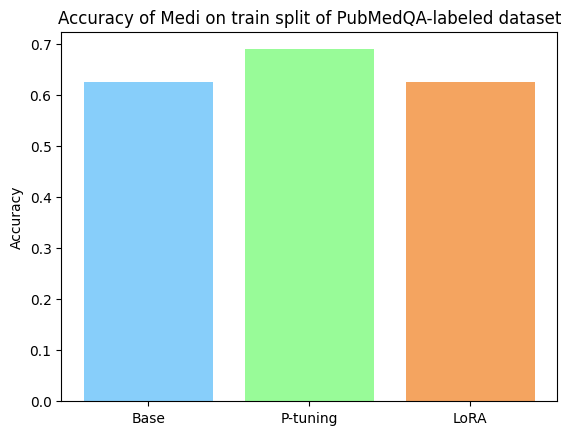

In [24]:
# display bar chart of accuracies on train split
display_bar_chart(base_accuracy, ptuning_accuracy, lora_accuracy, 'train')

<Figure size 400x400 with 0 Axes>

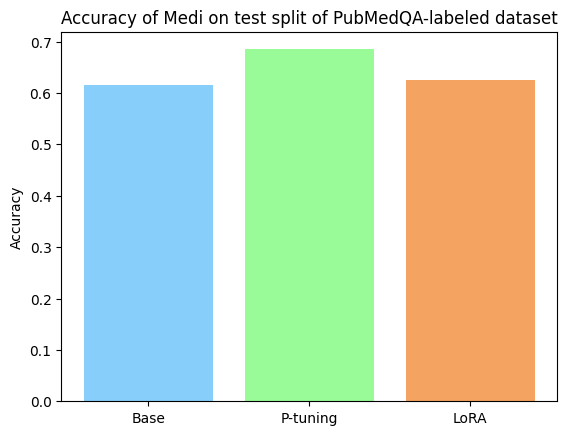

In [25]:
# display bar chart of accuracies on test split
display_bar_chart(base_accuracy, ptuning_accuracy, lora_accuracy, 'test')